<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Code Generation, Execution & Debugging

AutoGen offers conversable LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [1]:
# %pip install pyautogen>=0.2.3

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [1]:
from IPython.display import Image

import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [4]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "executor": "commandline",
        "commandline": {"work_dir": "coding", "user_docker": False},
        # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    },
)

# We use a local cache for reproducible results.
with autogen.Cache.disk() as cache:
    # the assistant receives a message from the user_proxy, which contains the task description
    user_proxy.initiate_chat(
        assistant,
        message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
        cache=cache,
    )

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

First, let's get the current date using Python. 

```python
# python code
from datetime import date

# Get today's date
today = date.today()

print("Today's date:", today)
```

Next, we need to fetch the stock prices for META (Facebook) and TESLA for the current year. We can use the `yfinance` library in Python to fetch this data. If `yfinance` is not installed, it can be installed using pip: `pip install yfinance`.

Here is the Python code to fetch the stock prices and calculate the year-to-date gain:

```python
# python code
import yfinance as yf
from datetime import datetime

# Get the current year
current_year = datetime.now().year

# Download stock data from the start of the year to today
meta_data = yf.download('FB', start=f'{current_year}-01-01', end=today)
tesla_data = yf.d

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, AutoGen defaults to the `autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto-generated.

## Example Task: Plot Chart

In [6]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

Sure, we can use the matplotlib library in Python to plot the stock price changes for META and TESLA. If matplotlib is not installed, it can be installed using pip: `pip install matplotlib`.

Here is the Python code to plot the stock prices and save the plot to a file:

```python
# python code
import matplotlib.pyplot as plt

# Plot the closing prices of META and TESLA
plt.figure(figsize=(14,7))
plt.plot(meta_data['Close'], label='META')
plt.plot(tesla_data['Close'], label='TESLA')

# Add title and labels
plt.title('Stock Price Change YTD for META and TESLA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Add legend
plt.legend()

# Save the plot to a file
plt.savefig('stock_price_ytd.png')
```

This code will create a line plot of the closing prices for META and TESLA from

Let's display the generated figure.

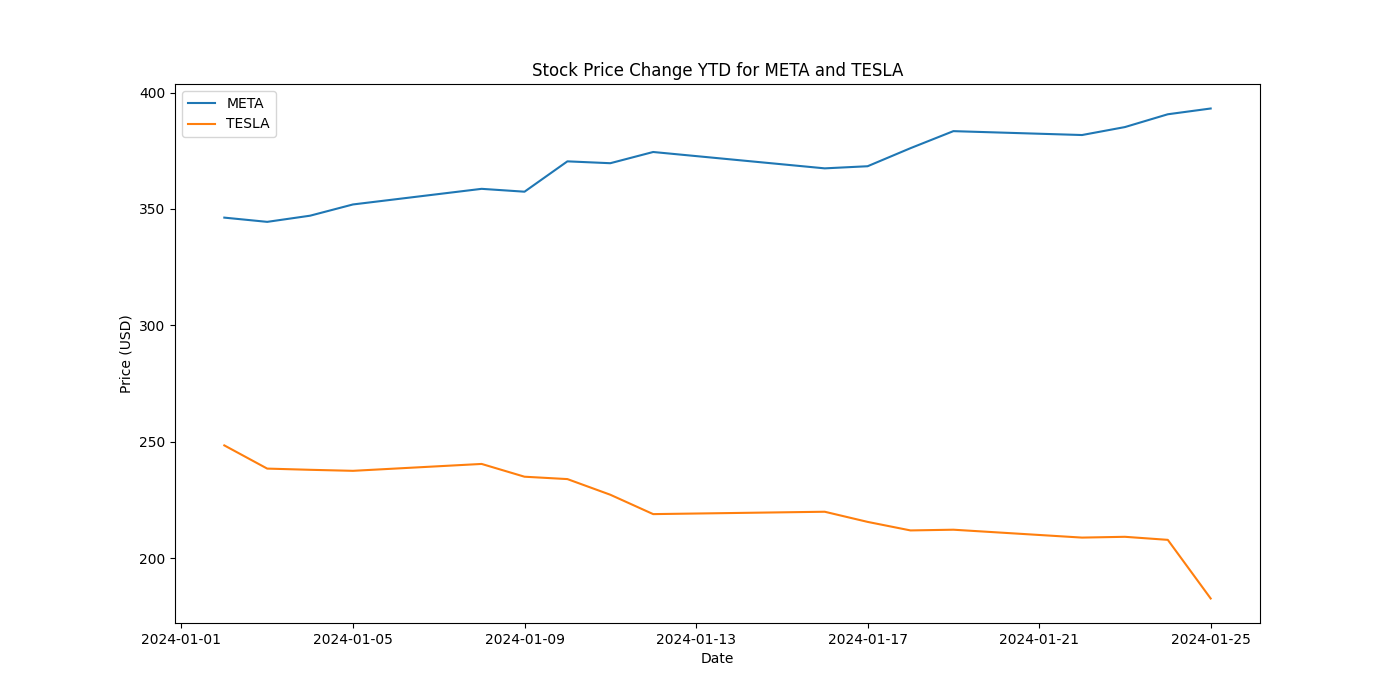

In [12]:
try:
    Image(filename="coding/stock_price_ytd.png")
except FileNotFoundError:
    print("Image not found. Please check the file name and modify if necessary.")

## Use IPython Code Execution Environment

In the previous example, code execution happened in a separate process in a command line environment,
which is not interactive and tends to waste a lot of LLM tokens on editing code script. 

In this example, we switch the execution environment to an IPython kernel which is interactive
and stateful.

In [2]:
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="ALWAYS",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={"executor": "ipython"},  # use IPython to execute the generated code
)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [3]:
assistant = autogen.ConversableAgent(
    name="assistant",
    system_message="You are a helpful AI assistant.",
    llm_config={
        "config_list": config_list,
        "temperature": 0,
    },
)

We are using a generic `ConversableAgent` as the `AssistantAgent`'s system
message is not compatible with IPython kernel.
To "teach" the generic `ConversableAgent` to understand how to use IPython kernel,
we need to add to it a "user capability" exported by the code executor.

In [4]:
user_proxy.code_executor.user_capability.add_to_agent(assistant)

Let's start the conversation with cache enabled.

In [5]:
with autogen.Cache.disk() as cache:
    # the assistant receives a message from the user, which contains the task description
    user_proxy.initiate_chat(
        assistant,
        message="""Plot a chart of META and TESLA stock price gain YTD.""",
    )

user_proxy (to assistant):

Plot a chart of META and TESLA stock price gain YTD.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
assistant (to user_proxy):

Sure, I can help with that. We will use the `yfinance` library to download the stock data. If it's not already installed, you can install it using pip:

```python
!pip install yfinance
```

After installing `yfinance`, we can proceed to download the stock data for META (Facebook) and TESLA. Let's start by importing the necessary libraries and downloading the data.

--------------------------------------------------------------------------------

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
assistant (to user_proxy):

```python
import yfinance as yf
import matplotlib

By using the IPython kernel as the execution environment, the code is generated
and executed incrementally rather than in a single script. This is more efficient
and can save a lot of LLM tokens on going back and forth between editing and executing.

Let's display the generated figure.

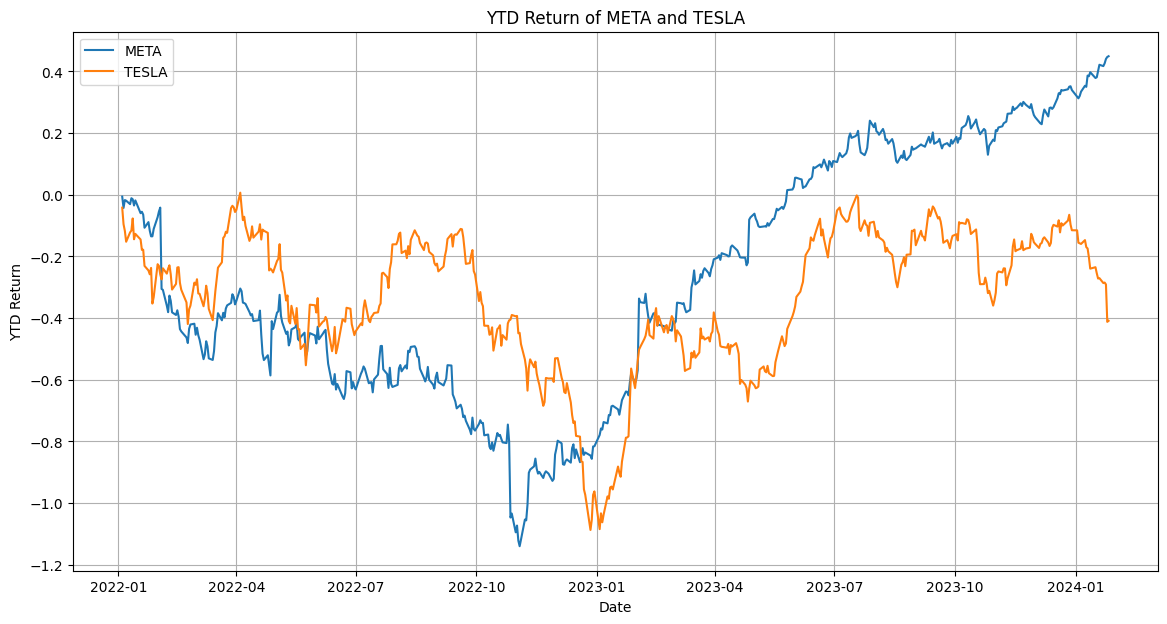

In [6]:
Image(filename="./18778f8594ab45df9a35a48a1dd8d0a2.png")

Remember, IPython kernel is stateful. If you want to start over, you need to
restart the executor.

In [7]:
user_proxy.code_executor.restart()

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
